<img src="images/ublogo.png"/>

### CSE610 - Bayesian Non-parametric Machine Learning

  - Lecture Notes
  - Instructor - Varun Chandola
  - Term - Fall 2020

### Objective
The objective of this notebook is to discuss Heteroscedastic regression using GP.

<div class="alert alert-info">

**Note:** This material is based on the 1998 paper - [Regression with input-dependent noise: A Gaussian process treatment](https://papers.nips.cc/paper/1444-regression-with-input-dependent-noise-a-gaussian-process-treatment.pdf), followed by the 2005 paper on this topic - [Heteroscedastic Gaussian Process Regression](https://cs.stanford.edu/~quocle/LeSmoCan05.pdf) and the related [GPy tutorial](https://nbviewer.jupyter.org/github/SheffieldML/notebook/blob/master/GPy/heteroscedastic_regression.ipynb). 

</div>

Usually, a GP regression model assumes that a set of targets $\{ y_1,\ldots,y_n \}$ is related to a set of inputs $\{ {\bf x }_1,\ldots, {\bf x }_n \}$ through the relation:
$$ y_i = f({\bf x}_i) + \epsilon_i, $$
where $f \sim \mathcal{GP}$ and $\epsilon_i \sim \mathcal{N}(0,\sigma_n^2)$ for all $i$.. 

A **heteroscedastic model** works in the same way, but allows different variances for the noise terms of the observations, i.e., 
$$
\epsilon_i \sim \mathcal{N}(0,\sigma_i^2)
$$
By adding this assumption, the model will now give different weights to each observation. Hence, it will try to fit better those observations with smaller noise and will be free not to fit very well those observations with larger noise.

Recall that the predictive equations for a *homoscedastic* GPR are:
\begin{eqnarray}
\bar{f}_* & = & {\bf k}_*^\top(K + \sigma_n^2I)^{-1}{\bf y}\\
var[f_*] & = & k({\bf x}_*,{\bf x}_*) - {\bf k}_*^\top(K + \sigma_n^2I)^{-1}{\bf k}_*
\end{eqnarray}

For heteroscedastic GPR, the predictive equations change to:
\begin{eqnarray}
\bar{f}_* & = & {\bf k}_*^\top(K + K_r)^{-1}{\bf y}\\
var[f_*] & = & k({\bf x}_*,{\bf x}_*) + r_* - {\bf k}_*^\top(K + K_r)^{-1}{\bf k}_*
\end{eqnarray}
where $K_r = \text{diag}({\bf r})$, ${\bf r}$ is a vector consisting of input noise variance for each training instance, and $r_*$ is the input noise variance for the test instance. 

### How do we specify ${\bf r}$?
There are more than one way to do this. The original paper by Goldberg et al., suggested using a second GP (referred to as the $z$-process) to model the noise. The ideas is to use the second GP to model the log of the noise level (to ensure that the output is positive). The values at the training data points are denoted by ${\bf z} = (z_1,z_2,\ldots,z_N)$, so that ${\bf r} = (\exp{(z_1)},\exp{(z_2)},\ldots,\exp{(z_N)})$. The covariance function is still defined over the inputs (${\bf x}s$), though the covariance function can have different form and hyper-parameters than the main GP prior.

In [2]:
%run Utilities.ipynb

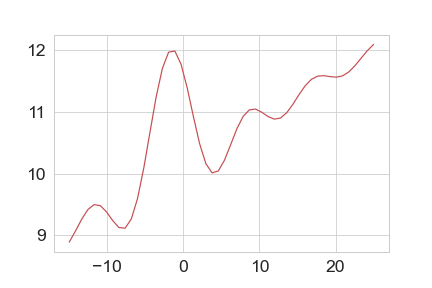

In [34]:
def f(X):
    return 10. + .1*X + 2*np.sin(X)/X

fig,ax = plt.subplots()
ax.plot(np.linspace(-15,25),f(np.linspace(-10,20)),'r-')

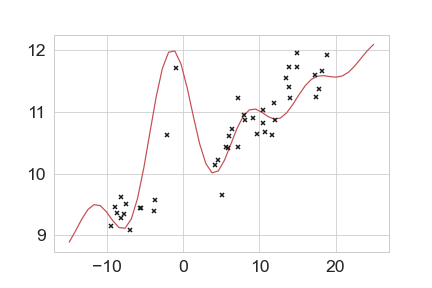

In [38]:
X = np.random.uniform(-10,20, 50)
X = X[~np.logical_and(X>-2,X<3)] #Remove points between -2 and 3 (just for illustration) 
X = np.hstack([np.random.uniform(-1,1,1),X]) #Prepend a point between -1 and 1  (just for illustration)
error = np.random.normal(0,.2,X.size)
Y = f(X) + error
fig,ax = plt.subplots()
ax.plot(np.linspace(-15,25),f(np.linspace(-10,20)),'r-')
ax.plot(X,Y,'kx',mew=1.5)


In [39]:
kern = GPy.kern.MLP(1) + GPy.kern.Bias(1)

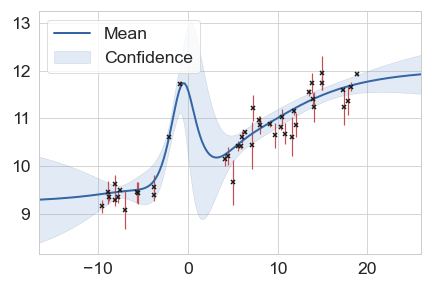

In [40]:
m = GPy.models.GPHeteroscedasticRegression(X[:,None],Y[:,None],kern)
m['.*het_Gauss.variance'] = abs(error)[:,None] #Set the noise parameters to the error in Y
m.het_Gauss.variance.fix() #We can fix the noise term, since we already know it
m.optimize()

m.plot_f() #Show the predictive values of the GP.
plt.errorbar(X,Y,yerr=np.array(m.likelihood.flattened_parameters).flatten(),
             fmt='none',color='r',linetype=None,zorder=1)
plt.plot(X,Y,'kx',mew=1.5)

Check how the predictions are not as good around training examples with higher uncertainty.